In [8]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models.senet import SeResNet
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/senet")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [9]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [10]:
num_class = len(dataset.classes)

# model

In [11]:
model = SeResNet(output_size=num_class, key=50).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
SeResNet                                           --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─SeBottleNeck: 3-4                      66,576
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─SeBottleNeck: 3-6                      78,864
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─SeBottleNeck: 3-8                      78,864
│    │    └─Identity: 3-9                          --
├─S

# training

In [13]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weigth_decapy=1e-5)

In [14]:
epochs = 10
acc_iters = 64 // BATCH_SIZE

In [15]:
training_loss = []

model.train()
for e in range(epochs):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

  0%|          | 0/1636 [00:00<?, ?it/s]

100%|██████████| 1636/1636 [17:50<00:00,  1.53it/s]


epoch 1: 0.025905563650413913


100%|██████████| 1636/1636 [05:49<00:00,  4.68it/s]


epoch 2: 0.01920019746466505


100%|██████████| 1636/1636 [05:46<00:00,  4.72it/s]


epoch 3: 0.016060559979743365


100%|██████████| 1636/1636 [05:47<00:00,  4.71it/s]


epoch 4: 0.013806696401600841


100%|██████████| 1636/1636 [05:44<00:00,  4.75it/s]


epoch 5: 0.01186020633971278


100%|██████████| 1636/1636 [05:25<00:00,  5.02it/s]


epoch 6: 0.010531409361301416


100%|██████████| 1636/1636 [05:26<00:00,  5.01it/s]


epoch 7: 0.009539057839158234


100%|██████████| 1636/1636 [05:26<00:00,  5.01it/s]


epoch 8: 0.008499849411475054


100%|██████████| 1636/1636 [05:24<00:00,  5.04it/s]


epoch 9: 0.0076206634593822655


100%|██████████| 1636/1636 [05:23<00:00,  5.06it/s]

epoch 10: 0.006685990006136571


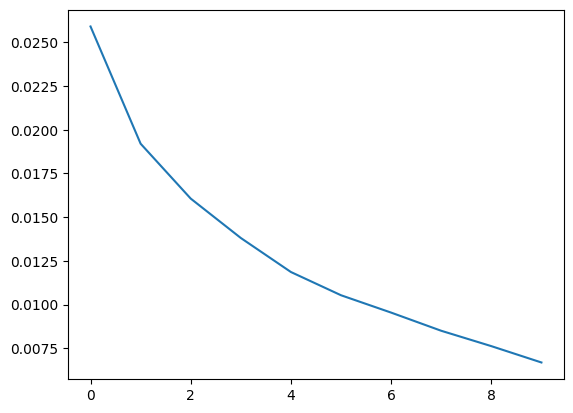

In [16]:
plt.plot(training_loss)

# inference

In [20]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [21]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [23]:
evaluator = ClassificationEvaluator(num_class, device)

In [24]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 1637/1637 [02:32<00:00, 10.70it/s]


In [25]:
print(confusion_matrix)

[[4384  102    1   22   35   66  100   39   18   96]
 [  91 2389    0    8   10    4   80   16    4   21]
 [  99  114 1052   15   14    6   50   23   15   58]
 [  17    4    0 1988   12    4    3    0   56   28]
 [  80   14    0   12 2874   18   20    5   18   57]
 [ 130    3    1    9    6 1369    8   10    8  124]
 [  63   87    4    2   10    2 1652   33    2   11]
 [  72   36    7    6   52   13  183 1392   18   41]
 [  22    9    0  144   11   12    5    4 4551   63]
 [  32    5    0    8    5    5    4    4   28 1771]]


In [26]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.9015011309891013
cavallo   : 0.9107891727030119
elefante  : 0.7275242047026279
farfalla  : 0.9412878787878788
gallina   : 0.9276952872821175
gatto     : 0.8207434052757794
mucca     : 0.8853161843515541
pecora    : 0.7648351648351648
ragno     : 0.9439950217797137
scoiattolo: 0.9511278195488722


In [27]:
per_class_acc.mean()

0.8774815270255821

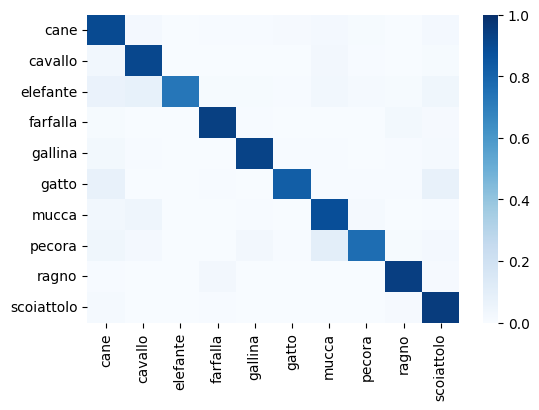

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [31]:
# image from internet
import requests
from io import BytesIO

# demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

In [ ]:
# randomly sampled from dataset

# import random
# idx = random.randint(0, len(dataset))
# sample = test_dataset[idx]
# img = sample[0].unsqueeze(0).to(device)

In [32]:
model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cavallo


In [17]:
model_path = artifact_path / 'se-resnet50.pth'

In [18]:
torch.save(model.state_dict(), model_path)

In [19]:
model_path.stat().st_size / 1024**2

99.74579048156738

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))